# Discrete solitons in Bose Hubbard model with nearest neighbors

We use a variational ansatz via pullback in the representation
of the characteristic function in the quantum phase space

The file contains also some code for saving and retrieving


<img src="../logo_circular.png" width="20" height="20" />@by claudio<br>
<br>nonlinearxwaves@gmail.com<br>
@created 3 May 2021<br>
@version 2 October 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

## Disable GPU

In [2]:
import os

In [3]:
DisableGPU=True
if DisableGPU:
    try:
        # Disable all GPUS        
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        #tf.config.set_visible_devices([], 'GPU')
        #visible_devices = tf.config.get_visible_devices()
        #for device in visible_devices:
        #    assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
else:
    print("Nothing to be done")

## Import and setup

In [4]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from thqml import phasespace as qx
from thqml import quantumsolitons as qs
import random

#### Default precision (tr_real and np_real as tf.float32 np.float32 or tf.float64 np.floatt)

In [5]:
tf_real = tf.float32
np_real = np.float32

In [6]:
np.set_printoptions(precision=4)

#### Check GPU

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Parameters

In [8]:
max_number_epochs=1000

In [9]:
period_display_epoch=max_number_epochs//10

In [10]:
period_checkpoint_epoch=period_display_epoch

In [11]:
BosonSampling=True # if true perform the boson sampling

In [12]:
CenterSolution=False # if true center the maximum of bosons

## Target total number of bosons

In [13]:
Ntarget=10

## Dimension

In [14]:
N=34

### Number of modes

In [15]:
n=int(N/2)
ncenter=int(n/2)
print(ncenter)

8


## Value for potential (this also named gamma)

In [16]:
chi=-1

# Init the quantum soliton python module

In [17]:
# bose hubbard model has L=n and U=chi
qs.init({"n":n,"dtype":tf_real,"chi":chi,"L":n,"model":"nnt"})
# Remark
# in the code chi is scaled with n/L in the potential energy
# thus setting L=n avoid this scaling (useful for other applications)

Setting Bose-Hubbard model L=n (non periodical)


## Check omega

In [18]:
print(qs.OMEGAR.numpy())

[[ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.]
 [ 0. 

## Save filename

In [19]:
claudio_arrays_file='./dataBH_N'+repr(N)+'Ntarget'+repr(Ntarget)+'U'+repr(qs.chi)+'/claudioarrays'
claudio_weights_file='./dataBH_N'+repr(N)+'Ntarget'+repr(Ntarget)+'U'+repr(qs.chi)+'/claudiomodel'

In [20]:
print(claudio_arrays_file)
print(claudio_weights_file)

./dataBH_N34Ntarget10U-1/claudioarrays
./dataBH_N34Ntarget10U-1/claudiomodel


## Dummy training points

In [21]:
Nbatch=1
beta_np=1
xtrain = np.random.rand(Nbatch, N)-0.5
ytrain=np.zeros([Nbatch,2])
for i1 in range(Nbatch):
    ytrain[i1]=0

## Create model

First define the vacuum layer

In [22]:
vacuum = qx.VacuumLayer(N,dtype=tf_real, name="Vacuum")

Then a trainable displacer

In [23]:
dtarget=0.1*np.ones([N,1],dtype=np_real)
D=qx.TrainableDisplacementLayer(dtarget,dtype=tf_real,name="Displacement")

We also need a series of layers for observable quantities
When needed these layers are Lambda layers obtained from functions

In [24]:
# covariance
CovL=qx.CovarianceLayer(N, name="covariance",dtype=tf_real)
# kinetic energy
KinL=tf.keras.layers.Lambda(qs.kinetic_energy, name="K",dtype=tf_real)
# boson numbers
BL=tf.keras.layers.Lambda(qs.gaussian_boson_numbers, name="Bosons",dtype=tf_real)
# total particle number
NL=tf.keras.layers.Lambda(tf.reduce_sum, dtype=tf_real,name="N")
# potential energy
VL=tf.keras.layers.Lambda(qs.potential_energy, dtype=tf_real,name="V")
# total hamiltonian
HL=tf.keras.layers.Lambda(qs.total_energy, dtype=tf_real,name="H")

Create the model for the ansatz state 
by cascading in reverse order
the vacuum, the squeezers, the displacer, the random interferomenter, and an input layer

In [25]:
# Create the boson sampling layer
xin = tf.keras.layers.Input(N, dtype=tf_real, name="Input")
x1 = xin
a1 = None
x1, a1=qx.RandomLayer(N,dtype=tf_real,name="R")(x1,a1)
x1, a1 = D(x1,a1)
for ij in range(n):
        r_np=0.1*np.random.rand(1)
        n_squeeze=ij
        theta_np=2.0*np.pi*np.random.rand(1)
        x1, a1 = qx.SingleModeSqueezerLayer(N, r_np=r_np, 
                                   theta_np=theta_np, n_squeezed=n_squeeze, trainable=True, 
                                   dtype=tf_real, name="S"+repr(ij))(x1,a1)    
chir, chii = vacuum(x1, a1)
# create the model with input and output
PSImodel = tf.keras.Model(inputs = xin, outputs=[chir, chii])    

Connect the model to the measurment layer

In [26]:
# connect the model to the covariance
cov, d, hessian = CovL(chir,chii, PSImodel)
# connect for kinetic energy
Ktotal=KinL([cov,d]) 
# boson numbers and squared boson number
[nboson,nboson2]=BL([cov,d,hessian])
# total number of particles
Ntotal=NL(nboson)   
# total potential energy
Vtotal=VL([nboson,nboson2])
# total hamiltonian
Htotal=HL([Ktotal, Vtotal])
# total particle
Ntarget_tf=tf.constant(Ntarget,dtype=tf_real)
# eigenvalues of covariance matrix
e, v = tf.linalg.eig(cov)
# define the cost function
expL=tf.exp(Htotal/n)
Ncenter_tf=tf.gather_nd(nboson,[[0,ncenter]])[0]
expNcenter=tf.exp(-Ncenter_tf)

## Callbacks

In [27]:
# checkpoint function
def savecheckpoint(num_epochs):
    model.save_weights(claudio_weights_file+'_cp_'+repr(num_epochs))
    np.savez(claudio_arrays_file+'_cp_'+repr(num_epochs),history_H=history_H,history_N=history_N,
             #history_beta=history_beta,
             history_eig=history_eig,history_negativity=history_negativity,nbosonout=nbosonout[0].numpy())
    print('Made checkpoint at epoch '+repr(num_epochs))

In [28]:
eig_model = tf.keras.Model(inputs = xin, outputs=e)    # print model
cov_model = tf.keras.Model(inputs = xin, outputs=cov)    # for covariance matrix
history_eig=[]
history_H=[]
history_N=[]
#history_beta=[]
history_negativity=[]
# mask for negativity (entropy)
nmask=np.zeros(n)
nmask[ncenter]=1
# custom callback
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        global history_eig
        #keys = list(logs.keys())
        eigs=eig_model(xtrain)
        history_eig.append(eigs.numpy()[-1])
        history_H.append(logs.get("H"))
        history_N.append(logs.get("N"))
        # history_beta.append(LL.get_weights()[0])
        Enegativity, _, _, _,_ =qs.logarithmic_negativity(cov_model(xtrain).numpy(),nmask)
        history_negativity.append(Enegativity)
        
        # display training info
        if np.mod(epoch, period_display_epoch)==0:
            print("Epoch "+repr(epoch)+
                  " of "+repr(max_number_epochs)+
                 " time "+repr(np.datetime64('now'))+
                  " H="+repr(np.around(logs.get("H"),decimals=3))+
                  " N="+repr(np.around(logs.get("N"),decimals=3)))
            
        # checkpoint at absolute value of the number of epochs
        if np.mod(epoch, period_checkpoint_epoch)==0:
            savecheckpoint(len(history_N)-1)

## Losses and metrics

In [29]:
model = tf.keras.Model(inputs = xin, outputs=expL)    # print model
model.add_loss(tf.reduce_mean(tf.square(Ntotal-Ntarget_tf)))
model.add_loss(expL)
if CenterSolution:
    model.add_loss(expNcenter)
model.add_metric(tf.reduce_mean(tf.square(Ntotal-Ntarget_tf)),name="Dn",aggregation="mean")
model.add_metric(expL,name="expF",aggregation="mean")
model.add_metric(Htotal,name="H",aggregation="mean")
model.add_metric(Ntotal,name="N",aggregation="mean")
model.compile(optimizer='adam')

## Load saved

In [30]:
# load data
load_data=False
if load_data:
    try:
        model.load_weights(claudio_weights_file)
        data_arrays=np.load(claudio_arrays_file+'.npz')
        data_arrays.files
        history_H=data_arrays['history_H'].tolist()
        history_N=data_arrays['history_N'].tolist()
        history_beta=data_arrays['history_beta'].tolist()
        history_eig=data_arrays['history_eig'].tolist()
        history_negativity=data_arrays['history_negativity'].tolist()
        print("Loaded data")
        plt.figure(1)
        plt.plot(history_H)
        plt.title('H')
        plt.figure(2)
        plt.plot(history_N)
        plt.title('N')
        plt.title('beta')
        plt.figure(4)
        plt.plot(np.real(history_eig))
        plt.title('eig')
        plt.figure(5)
        plt.plot(np.real(history_negativity))
        plt.title('negativity')
    except: 
        print("No stored data found")

## Test

tf.Tensor(
[[0.013  0.0095 0.0068 0.0129 0.0128 0.021  0.0162 0.0129 0.0163 0.0107
  0.0105 0.0205 0.0134 0.0187 0.0101 0.0124 0.0141]], shape=(1, 17), dtype=float32)
tf.Tensor(0.23182112, shape=(), dtype=float32)
H=-0.3024984
K=-0.29663074
V=-0.00586766
N=0.23182112


<StemContainer object of 3 artists>

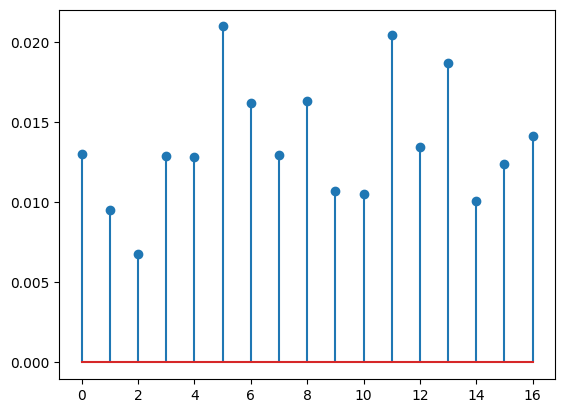

In [31]:
# display obserbables
Bmodel = tf.keras.Model(inputs = xin, outputs=[nboson,Htotal,Vtotal, Ktotal, Ntotal,d])    # print model
nbosonout, Hout, Vout, Kout, Nout,dout=Bmodel(xtrain) 
print(nbosonout)
print(tf.math.reduce_sum(nbosonout))
print("H="+repr(Hout.numpy()))
print("K="+repr(Kout.numpy()))
print("V="+repr(Vout.numpy()))
print("N="+repr(Nout.numpy()))
plt.stem(nbosonout[0].numpy())

# Save initial model

In [32]:
len(history_H)

0

In [33]:
# save model and arrays with initial stamp (only save if length of history_H is small)
if len(history_H)==0:
    model.save_weights(claudio_weights_file+'_initial')
    np.savez(claudio_arrays_file+'_initial',history_H=history_H,history_N=history_N,
             history_eig=history_eig,history_negativity=history_negativity,nbosonout=nbosonout[0].numpy())

## Train

In [34]:
total_trainable_parameters=np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print("Model trainable weights "+repr(total_trainable_parameters))

Model trainable weights 646


In [35]:
%%time
# train
# timing after the first run of training that takes around a dubled time
# N=32 100 epochs in 5.3 s with noGPU
# N=32 100 epochs in 11.7 s with GPU

print("Training model ...")
if max_number_epochs>0:
    history=model.fit(xtrain,ytrain,epochs=max_number_epochs,verbose=0, callbacks=[CustomCallback()])    
    print("Initial loss "+repr(history.history['loss'][0]))
    print("  Final loss "+repr(history.history['loss'][-1]))
    print(" ################################### ")
results=model.evaluate(xtrain,ytrain)

Training model ...
Epoch 0 of 1000 time numpy.datetime64('2023-10-02T08:01:08') H=-0.302 N=0.232
Made checkpoint at epoch 0
Epoch 100 of 1000 time numpy.datetime64('2023-10-02T08:01:15') H=-1.801 N=1.277
Made checkpoint at epoch 100
Epoch 200 of 1000 time numpy.datetime64('2023-10-02T08:01:22') H=-5.751 N=3.594
Made checkpoint at epoch 200
Epoch 300 of 1000 time numpy.datetime64('2023-10-02T08:01:29') H=-12.063 N=6.626
Made checkpoint at epoch 300
Epoch 400 of 1000 time numpy.datetime64('2023-10-02T08:01:36') H=-17.94 N=8.944
Made checkpoint at epoch 400
Epoch 500 of 1000 time numpy.datetime64('2023-10-02T08:01:44') H=-21.003 N=9.83
Made checkpoint at epoch 500
Epoch 600 of 1000 time numpy.datetime64('2023-10-02T08:01:55') H=-22.769 N=10.003
Made checkpoint at epoch 600
Epoch 700 of 1000 time numpy.datetime64('2023-10-02T08:02:06') H=-23.467 N=10.024
Made checkpoint at epoch 700
Epoch 800 of 1000 time numpy.datetime64('2023-10-02T08:02:17') H=-23.738 N=10.026
Made checkpoint at epoch 8

In [36]:
# save model and arrays
model.save_weights(claudio_weights_file)
np.savez(claudio_arrays_file,history_H=history_H,history_N=history_N,
         history_eig=history_eig,history_negativity=history_negativity)

In [37]:
# save model and arrays with epoch stamp including nboson out
if max_number_epochs>0:
    model.save_weights(claudio_weights_file+'_'+repr(len(history_H)))
    np.savez(claudio_arrays_file+'_'+repr(len(history_H)),history_H=history_H,history_N=history_N,
         history_eig=history_eig,history_negativity=history_negativity,nbosonout=nbosonout[0].numpy())

Text(0.5, 1.0, 'negativity')

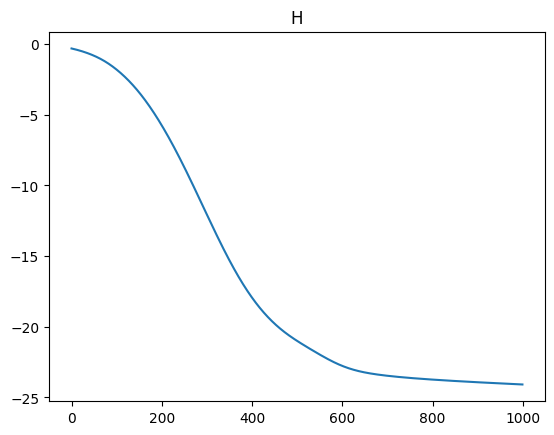

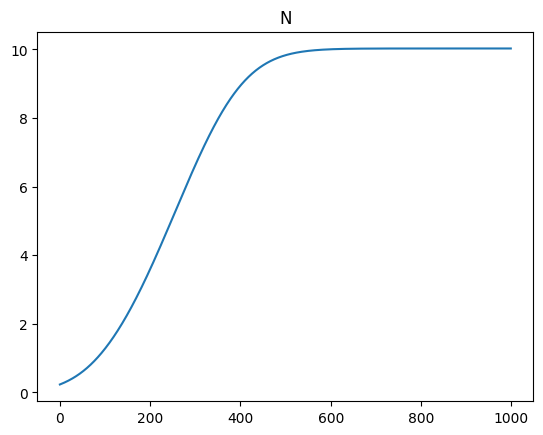

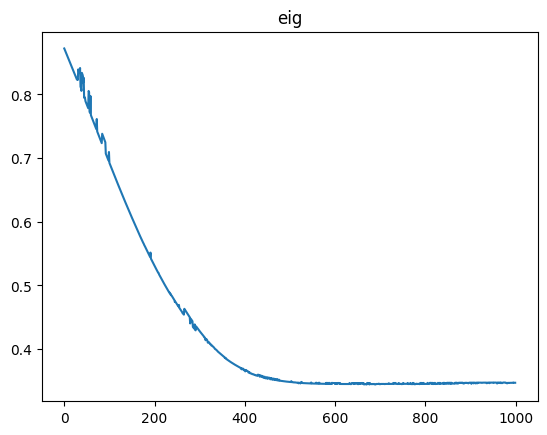

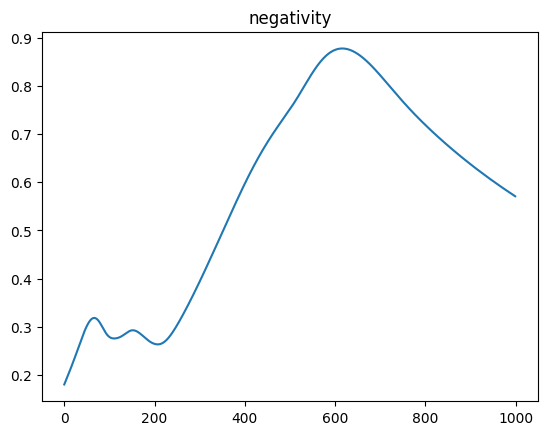

In [38]:
plt.figure(1)
plt.plot(history_H)
plt.title("H")
plt.figure(2)
plt.plot(history_N)
plt.title("N")
plt.figure(3)
plt.plot(np.real(history_eig))
plt.title("eig")
plt.figure(4)
plt.plot(history_negativity)
plt.title("negativity")

tf.Tensor(
[[0.3085 0.3086 0.3095 0.3101 0.3124 0.3093 0.3246 0.5607 4.5457 0.5631
  0.323  0.3087 0.3107 0.3083 0.3071 0.3078 0.3085]], shape=(1, 17), dtype=float32)
tf.Tensor(10.0265465, shape=(), dtype=float32)
H=-24.084362
K=-4.409608
V=-19.674755
N=10.0265465
orderparameter=-0.193367


<StemContainer object of 3 artists>

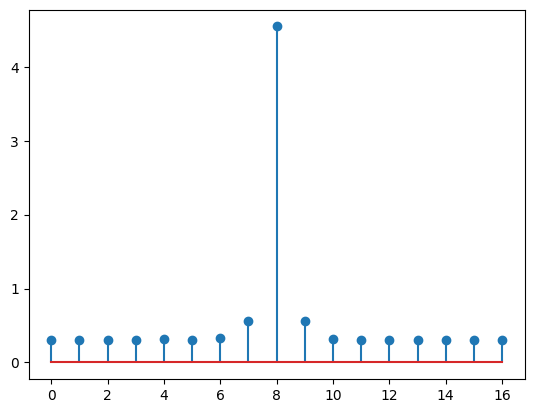

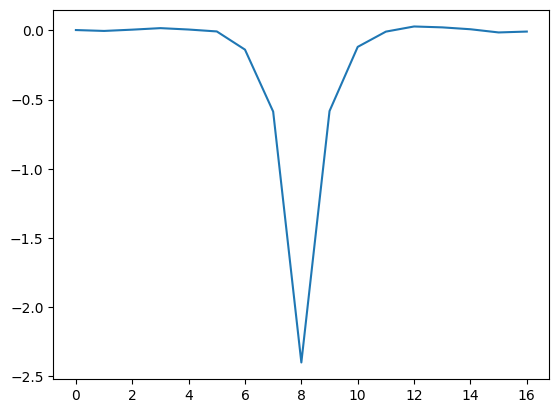

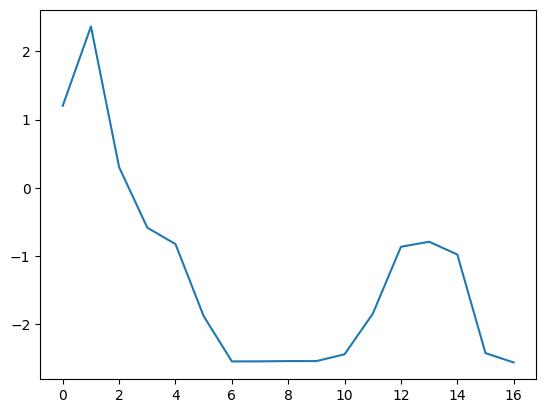

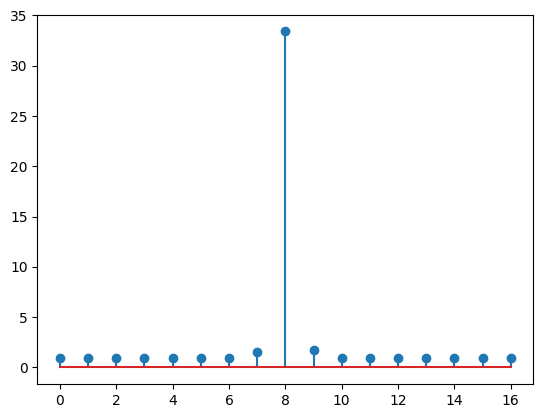

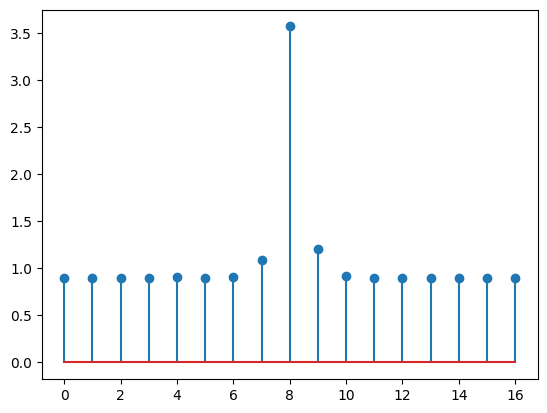

In [39]:
Bmodel = tf.keras.Model(inputs = xin, outputs=[nboson,nboson2,Htotal,Vtotal, Ktotal, Ntotal, cov, d])    # print model
nbosonout,nbosonout2, Hout, Vout, Kout, Nout,covout, dout=Bmodel(xtrain) 
print(nbosonout)
print(tf.math.reduce_sum(nbosonout))
print("H="+repr(Hout.numpy()))
print("K="+repr(Kout.numpy()))
print("V="+repr(Vout.numpy()))
print("N="+repr(Nout.numpy()))
print("orderparameter="+repr(np.mean(dout.numpy())))

plt.figure(6)
plt.stem(nbosonout[0])
plt.figure(7)
tmpr=dout[0][0::2]
plt.plot(tmpr)
plt.figure(8)
tmpi=dout[0][1::2]
plt.plot(np.angle(tmpr.numpy()+1j*tmpi.numpy()))
plt.figure(10)
plt.stem(nbosonout2[0])
plt.figure(11)
plt.stem(np.sqrt(nbosonout2[0]-nbosonout[0]**2))

# Boson sampling the model

In [40]:
if not(BosonSampling):
    raise Exception("Finished code")

## Make the Q-trasform of the model

In [41]:
kin, Qrho=qx.getQTransformModel(PSImodel)
Qfun = qx.QTransform(covout,dout)

In [42]:
Qrho.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             1836      
 rmLayer)                                                        
                                                                 
Total params: 1,836
Trainable params: 646
Non-trainable params: 1,190
_________________________________________________________________


In [43]:
qx.Pr([0]*n, Qfun)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0047]], dtype=float32)>

CPU times: user 402 ms, sys: 41 µs, total: 402 ms
Wall time: 401 ms


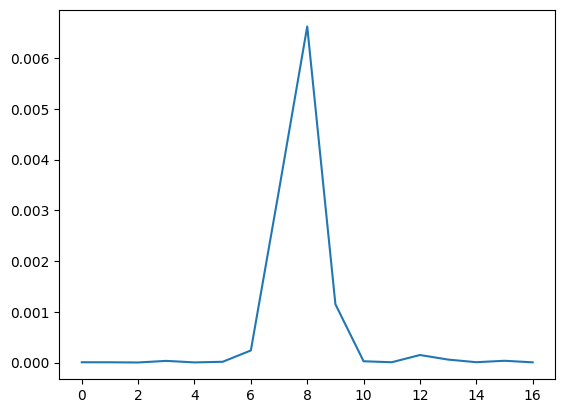

In [44]:
%%time
nphoton=1
out=[0]*n
for ij in range(n):
    nsample=[0]*n
    nsample[ij]=nphoton
    out[ij]=qx.Pr(nsample, Qfun)
plt.plot(out)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


/tmp/ipykernel_17239/1233197944.py:18: RuntimeWarning: divide by zero encountered in log
  plt.stem(np.log(out)) # gives a warning in the plot if zero


<StemContainer object of 3 artists>

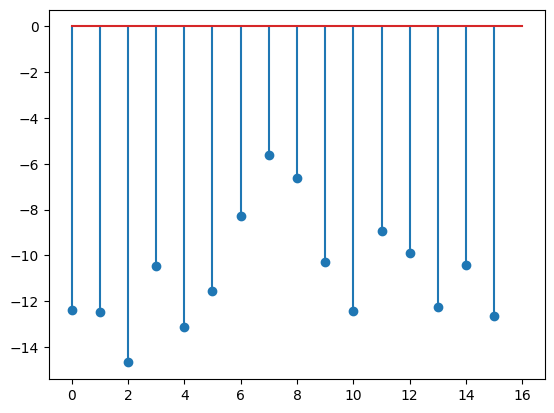

In [45]:
# probability of 2 photons
%time
ijcenter=ncenter
out=np.zeros(n)
# two photons on the soliton
c=0
for ij in range(n):
    nsample=[0]*n
    nsample[ijcenter]=1
    if np.not_equal(ij,ijcenter):
        nsample[ij]=1
        print(nsample)
        out[c]=qx.Pr(nsample, Qfun)
        c=c+1
#    else: #count 2 photon on the soliton peak
#        nsample[ij]=2    
        
plt.stem(np.log(out)) # gives a warning in the plot if zero

Computing nphoton 0
Computing nphoton 1
Computing nphoton 2
Computing nphoton 3
Computing nphoton 4
CPU times: user 4.12 s, sys: 7.43 ms, total: 4.13 s
Wall time: 4.13 s


<StemContainer object of 3 artists>

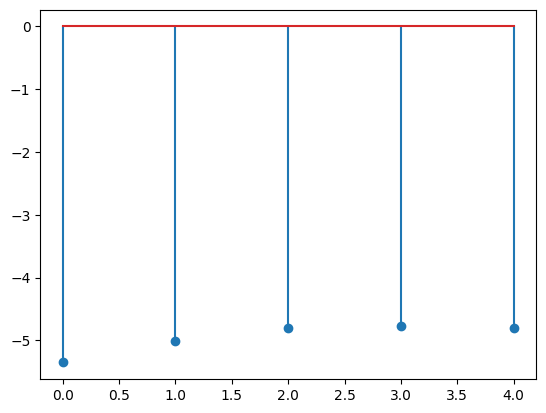

In [46]:
%%time
#probability of finding maxnphoton photons in the soliton
maxnphoton=5
outp=np.zeros(maxnphoton)
for ij in range(maxnphoton):
    nsample=[0]*n
    nsample[ijcenter]=ij
    print("Computing nphoton "+repr(ij))
    outp[ij]=qx.Pr(nsample, Qfun)
plt.stem(np.log(outp))

# PLOT MODEL

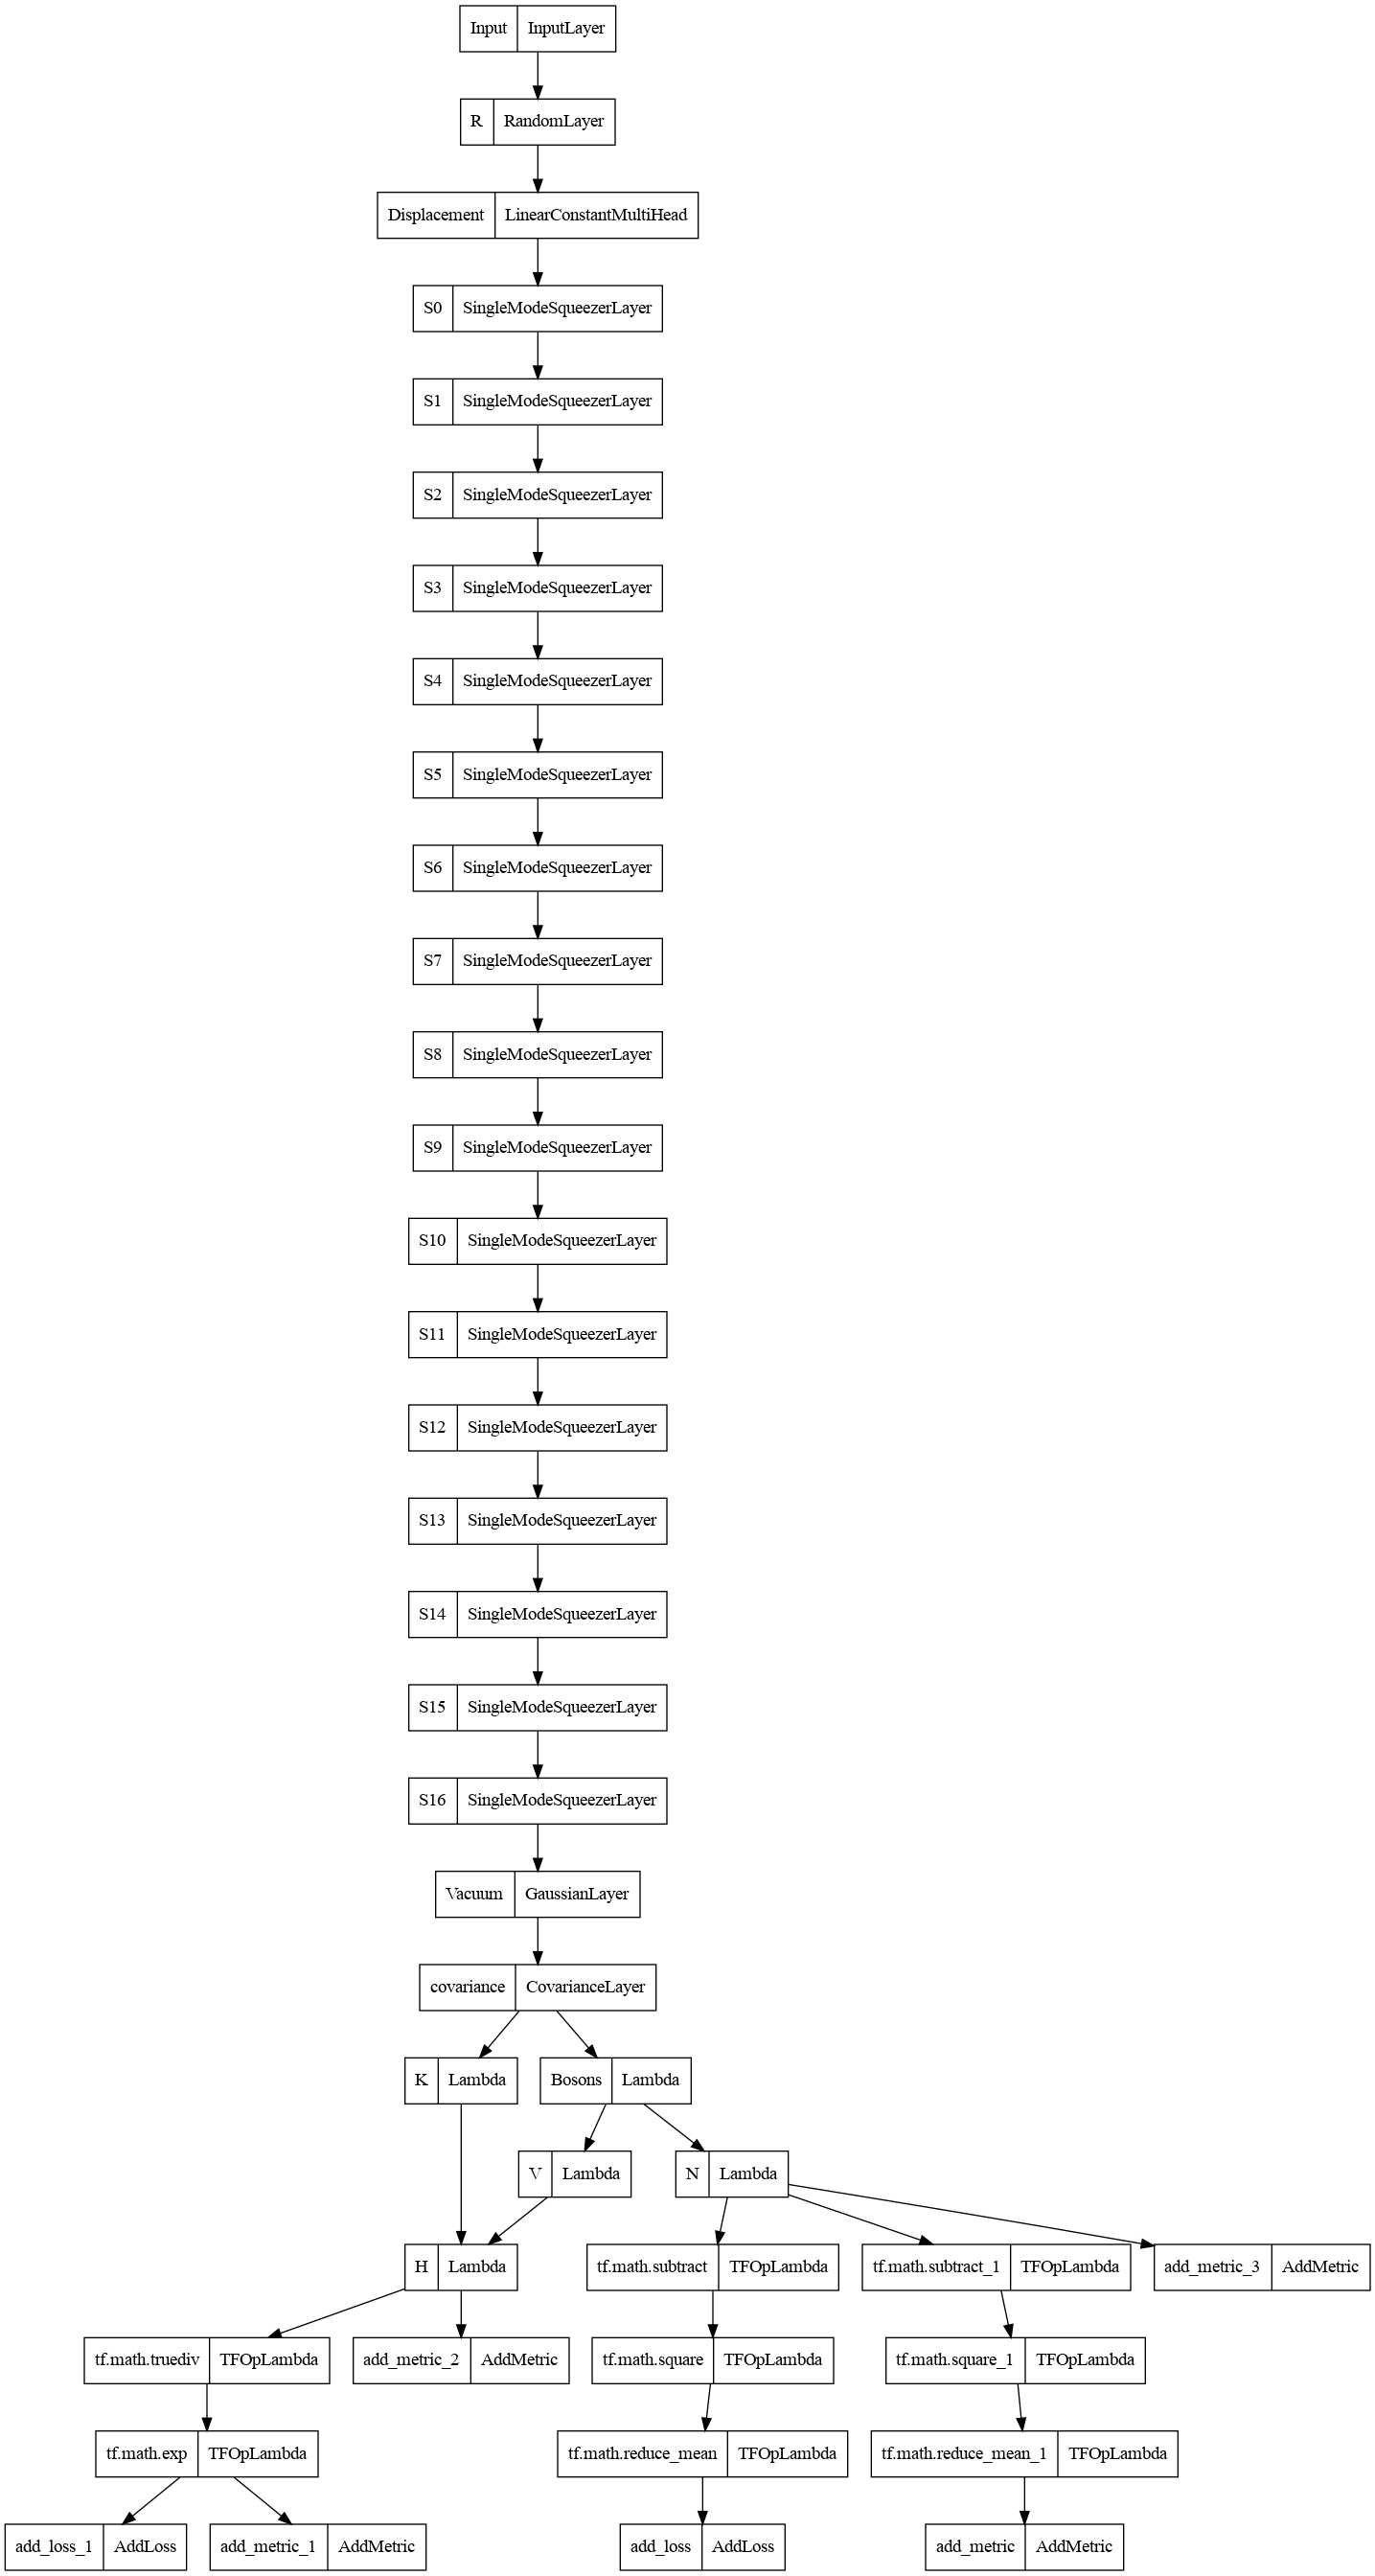

In [47]:
tf.keras.utils.plot_model(model)